[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/owenmccadden/machine_learning/blob/main/csc44800/assignment_3/austin_housing_market.ipynb)

# Trends in the Austin Housing Market 2021

In [2]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

## Abstract

I thought it would be interesting to look at the relationships between the attributes of a home and the price of a home. I found this dataset on [Kaggle](kaggle.com/ericpierce/austinhousingprices) with about 15k homes in the Austin area each with 47 attributes. The data was scraped from [Zillow](http://Zillow.com) via [apify](http://apify.com) on January 31st, 2021. 

I will use Linear Regression to predict the price of a home based on 
- the living area of the property in square feet
- several other attributes

I will also use a Neural Network to classify whether or not the home has a Homeowner's Association based on some of it's attributes.

## Section 1: Prepping the Regression Datasets

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/owenmccadden/machine_learning/main/csc44800/assignment_3/austinHousingData.csv")
df = df.set_index("zpid")
df.head(15)

,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,...,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage
zpid,,,,,,,,,,,,,,,,,,,,,
111373431,pflugerville,14424 Lake Victor Dr,78660,"14424 Lake Victor Dr, Pflugerville, TX 78660 i...",30.430632,-97.663078,1.98,2,True,True,...,1,1,1.266667,2.666667,1063,14,3.0,4,2,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f...
120900430,pflugerville,1104 Strickling Dr,78660,Absolutely GORGEOUS 4 Bedroom home with 2 full...,30.432673,-97.661697,1.98,2,True,True,...,1,1,1.400000,2.666667,1063,14,2.0,4,1,120900430_8255c127be8dcf0a1a18b7563d987088-p_f...
2084491383,pflugerville,1408 Fort Dessau Rd,78660,Under construction - estimated completion in A...,30.409748,-97.639771,1.98,0,True,True,...,1,1,1.200000,3.000000,1108,14,2.0,3,1,2084491383_a2ad649e1a7a098111dcea084a11c855-p_...
120901374,pflugerville,1025 Strickling Dr,78660,Absolutely darling one story home in charming ...,30.432112,-97.661659,1.98,2,True,True,...,1,1,1.400000,2.666667,1063,14,2.0,3,1,120901374_b469367a619da85b1f5ceb69b675d88e-p_f...
60134862,pflugerville,15005 Donna Jane Loop,78660,Brimming with appeal & warm livability! Sleek ...,30.437368,-97.656860,1.98,0,True,True,...,1,1,1.133333,4.000000,1223,14,3.0,3,2,60134862_b1a48a3df3f111e005bb913873e98ce2-p_f.jpg
2080105342,pflugerville,14908 Spring Hill Ln,78660,"14908 Spring Hill Ln, Pflugerville, TX 78660 i...",30.437775,-97.656181,1.98,2,True,True,...,1,1,1.066667,4.000000,1223,14,2.0,3,1,2080105342_553d16748c296fce71f33902edd98d2d-p_...
241932337,pflugerville,14009 Cantata Ln,78660,This well-maintained 2016 home in the Retreat ...,30.414684,-97.643394,1.98,0,True,False,...,1,1,1.233333,3.666667,1051,12,3.0,4,2,241932337_78e2a51227f811bd3c65d6674e8a7939-p_f...
60134835,pflugerville,15009 Drusillas Dr,78660,"Wonderful home, freshly painted throughout, ne...",30.439404,-97.658035,1.98,0,True,True,...,1,1,1.166667,4.000000,1223,14,3.0,3,2,60134835_47efc51704a66b45a8a134022ceeddb1-p_f.jpg
60134833,pflugerville,1104 Traci Michelle Dr,78660,Solid 3 bed 2 bath with formal dining/living c...,30.439096,-97.657959,1.98,0,True,True,...,1,1,1.166667,4.000000,1223,14,2.0,3,2,60134833_aa596c71096f40a535ce679c788cae36-p_f.jpg


We've got a ton of data here. It looks like there are a lot of Homeowner's Associations in Pflugerville... 

For now, I'll be focusing on:
- livingAreaSqFt: Size of the living area in square feet
- latestPrice: latest price of the home (as of Jan 31st, 2021), the value we want to predict

To clean the data, I'm removing a couple of oversized homes far larger than all the others

In [4]:
df = df.drop([70330356, 64523076])

## Section 2: Linear Regression

### Simple Regression: Living Area Square Footage and Latest Price

In [5]:
df[['livingAreaSqFt', 'latestPrice']].head(15)

,livingAreaSqFt,latestPrice
zpid,,
111373431,2601.0,305000.0
120900430,1768.0,295000.0
2084491383,1478.0,256125.0
120901374,1678.0,240000.0
60134862,2132.0,239900.0
2080105342,1446.0,309045.0
241932337,2432.0,315000.0
60134835,1422.0,219900.0
60134833,1870.0,225000.0


In [8]:
def get_score(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    reg = LinearRegression()
    reg.fit(x_train, y_train)
    reg.predict(x_test)
    return reg.score(x_test, y_test)

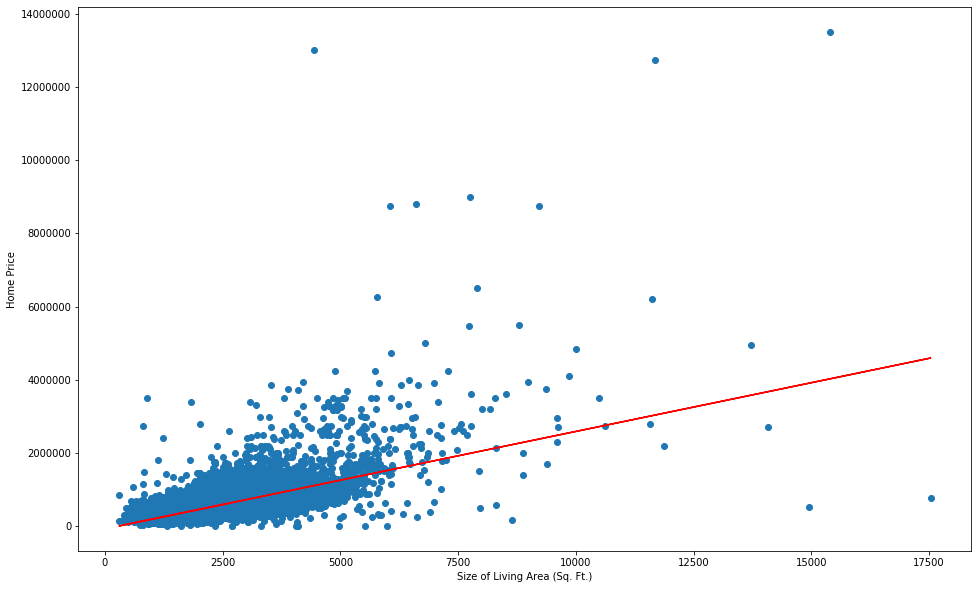

In [12]:
x = df[['livingAreaSqFt']]
y = df['latestPrice']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
reg = LinearRegression()
reg.fit(x_train, y_train)
fig, ax = plt.subplots()
fig.set_size_inches(16, 10)
ax.ticklabel_format(useOffset=False, style='plain')
plt.scatter(x, y)
m = reg.coef_[0]
b = reg.intercept_
plt.plot(x, m*x + b, color="red")
plt.ylabel('Home Price')
plt.xlabel("Size of Living Area (Sq. Ft.)")
plt.show()

In [13]:
scores = []
for i in range(100):
    scores.append(get_score(x, y))

print("Mean score: {}".format(np.mean(scores)))
print("Standard Deviation {}".format(np.std(scores)))

Mean score: 0.37456738972006454
Standard Deviation 0.042248058133294145


### Initial Results:

Based on our model it looks like living area square footage is a decent but not great predictor of latest home price. Our regression score comes out to roughly 37% accuracy. This makes sense with our given dataset because there are some  extreme values that I did not remove that throw off the trend.

Now let's try using multiple regression and adding a few more independent variables.

### Multiple Regression

In [14]:
x = df[[
    'yearBuilt','garageSpaces','livingAreaSqFt','avgSchoolRating','numOfBathrooms','numOfBedrooms','numOfStories'
]]
y = df['latestPrice']
scores = []
for i in range(100):
    scores.append(get_score(x, y))

print("Mean score: {}".format(np.mean(scores)))
print("Standard Deviation {}".format(np.std(scores)))


Mean score: 0.44527047401085335
Standard Deviation 0.04000300080090319


### Results:
 
It looks like the regression model is a bit more accurate now with more variables. Now we're getting an average score of about 45% accuracy with a standard deviation of about 5%.

## Section 3: Classification Dataset Prep

For this section, I'll be using the same dataset. I will be attempting to classify whether or not a home is part of a Homeowner's Association based on its attributes. 

I'll use the following attributes:
- hasGarage - possible values are True or False
- homeType
- livingAreaSqFt

To classify:
- hasAssociation - possible values are True or False

For my data mappings, I will map True to 1 and False to 0.

I will also map the homeType as follows: 

{'Single Family': 1,
'Residential': 2,
'Mobile / Manufactured': 3,
'Townhouse': 4,
'Condo': 5,
'Vacant Land': 6,
'Multiple Occupancy': 7,
'Other': 8,
'Apartment': 9,
'MultiFamily': 10}



In [15]:
df['hasGarage'] = df['hasGarage'].astype(int)
df['hasAssociation'] = df['hasAssociation'].astype(int)

In [16]:
home_types = {}
mapping = 1
homes = list(df['homeType'])
for i in range(len(homes)):
    if homes[i] not in home_types:
        home_types[homes[i]] = mapping
        mapping += 1
    homes[i] = home_types[homes[i]]

df['homeType'] = homes
home_types

{'Single Family': 1,
 'Residential': 2,
 'Mobile / Manufactured': 3,
 'Townhouse': 4,
 'Condo': 5,
 'Vacant Land': 6,
 'Multiple Occupancy': 7,
 'Other': 8,
 'Apartment': 9,
 'MultiFamily': 10}

In [17]:
df[['hasGarage', 'homeType', 'livingAreaSqFt', 'hasAssociation']].head(15)

,hasGarage,homeType,livingAreaSqFt,hasAssociation
zpid,,,,
111373431,1,1,2601.0,1
120900430,1,1,1768.0,1
2084491383,0,1,1478.0,1
120901374,1,1,1678.0,1
60134862,0,1,2132.0,1
2080105342,1,1,1446.0,1
241932337,0,1,2432.0,1
60134835,0,1,1422.0,1
60134833,0,1,1870.0,1


## Section 4: Classification with a Neural Network

In [18]:
def get_classification_score(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(3, 1), random_state=1)
    clf.fit(x, y)
    clf.predict(x_test)
    return clf.score(x_test, y_test)

In [19]:
x = df[['hasGarage','homeType','livingAreaSqFt']]
y = df['hasAssociation']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(3, 1), random_state=1)
clf.fit(x_train, y_train)
for coef in clf.coefs_:
    print(coef)

clf.score(x_test, y_test)

[[-0.16595599  0.44064899 -0.99977125]
 [-0.39533485 -0.70648822 -0.81532281]
 [-0.62747958 -0.30887855 -0.20646505]]
[[-0.72394118]
 [ 0.92619478]
 [-1.15765924]]
[[-0.28124208]]


0.5392221489782465

In [20]:
scores = []
for i in range(100):
    scores.append(get_classification_score(x, y))

print("Mean score: {}".format(np.mean(scores)))
print("Standard Deviation {}".format(np.std(scores)))

Mean score: 0.5280454845088992
Standard Deviation 0.008139812793063524


### Initial Results

It looks like our neural network is about 53% accurate at classifying homes as memebers of homeowner associations, so it's preforming slightly better than random. This seems to make sense because I chose pretty arbitrary predictor variables. Now I'll try adding some more variables.

In [21]:
df[['hasGarage', 'homeType', 'livingAreaSqFt', 'numOfStories', 'MedianStudentsPerTeacher', 'avgSchoolSize', 'hasAssociation']].head(15)

,hasGarage,homeType,livingAreaSqFt,numOfStories,MedianStudentsPerTeacher,avgSchoolSize,hasAssociation
zpid,,,,,,,
111373431,1,1,2601.0,2,14,1063,1
120900430,1,1,1768.0,1,14,1063,1
2084491383,0,1,1478.0,1,14,1108,1
120901374,1,1,1678.0,1,14,1063,1
60134862,0,1,2132.0,2,14,1223,1
2080105342,1,1,1446.0,1,14,1223,1
241932337,0,1,2432.0,2,12,1051,1
60134835,0,1,1422.0,2,14,1223,1
60134833,0,1,1870.0,2,14,1223,1


In [22]:
x = df[['hasGarage', 'homeType', 'livingAreaSqFt', 'numOfStories', 'MedianStudentsPerTeacher', 'avgSchoolSize']]
y = df['hasAssociation']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(3, 1), random_state=1)
clf.fit(x_train, y_train)
for coef in clf.coefs_:
    print(coef)

clf.score(x_test, y_test)

[[-0.1356858   0.35978839 -0.81636822]
 [-0.32384631 -0.57684521 -0.66611717]
 [-0.91152573 -0.25219828 -0.3043653 ]
 [ 0.06277958 -0.13195481  0.302248  ]
 [-0.49183426  0.61746319 -0.77500493]
 [-0.57661062 -0.13504069 -0.2019418 ]]
[[ 1.12227983]
 [-0.45701556]
 [ 0.46471491]]
[[1.36704292]]


0.46176664469347395

In [23]:
scores = []
for i in range(100):
    scores.append(get_classification_score(x, y))

print("Mean score: {}".format(np.mean(scores)))
print("Standard Deviation {}".format(np.std(scores)))

Mean score: 0.4728081740276862
Standard Deviation 0.00811781605535015


### Results

Well it looks like adding these additional variables has made the model less accurate. It looks like this Neural Network is not an effective predictor of whether a home is part of a Homeowner's Association.

## Conclusion

In summary, the models I created are not great predictors of home price or Homeowner's Association membership. 

This could indicate that home price is more subjective and not always a direct result of its attributes, or it could be that my Linear Regression model does not use a good combination of variables, or a bit of both. 

Likewise, the Neural Network I used was not a very accurate predictor of Homeowner's Association membership. Maybe there is a different set of variables that would be a better predictor, or maybe the model I created needs to be tweaked.

It would be interesting to create a model that can accurate predict the price of a home, and use that to predict the change in home prices overtime. Would be cool to use this model with the Zillow API in different regions of the country to monitor trends in different housing markets.